# Set up paths

In [73]:
from pathlib import Path

project_dir = Path('.').absolute()
project_dir

model_dir = project_dir / 'logs' / 'ppo' / 'A1GymEnv-v0_44'
stats_dir = model_dir / 'stats'

In [74]:
import gym 
import utils.import_envs

env = gym.make("A1GymEnv-v0")
foot_names = env.robot.GetFootNames()

Init CPG gait=trot, duty_factor=0.5, period=0.6343878881252295
argv[0]=


/home/dtch1997/anaconda3/envs/rl-baselines3-zoo/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Load logged quantities

Logs generated with `scripts/enjoy_with_logging.py`

In [75]:
import numpy as np
import pickle 
import json

def load_robot_states(stats_dir):
    base_position = np.load(stats_dir / 'base_position.npy')
    base_velocity = np.load(stats_dir / 'base_velocity.npy')
    motor_position = np.load(stats_dir / 'motor_position.npy')
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    motor_torque = np.load(stats_dir / 'motor_torque.npy')
    ref_displacement = np.load(stats_dir / 'reference_displacement.npy')
    act_displacement = np.load(stats_dir / 'actual_displacement.npy')
    ref_foot_contacts = np.load(stats_dir / 'reference_foot_contact.npy')
    act_foot_contacts = np.load(stats_dir / 'actual_foot_contact.npy')
    nn_observations = np.load(stats_dir / 'nn_observations.npy')

    reward_component_values = np.load(stats_dir / 'reward_components.npy')
    with open(stats_dir / 'reward_component_names.json', 'r') as file:
        reward_component_names = json.load(file)
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    time = np.load(stats_dir / 'time.npy')
    
    return {
        'time': time, 
        'base_pos': base_position,
        'base_vel': base_velocity,
        'motor_pos': motor_position, 
        'motor_vel': motor_velocity, 
        'motor_torque': motor_torque,
        'ref_displacement': ref_displacement,
        'act_displacement': act_displacement,
        'ref_foot_contacts': ref_foot_contacts, 
        'act_foot_contacts': act_foot_contacts, 
        'nn_obs': nn_observations,
        'nn_act': nn_actions,
        'reward_component_values': reward_component_values,
        'reward_component_names': reward_component_names
    }

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

In [76]:
stats = load_robot_states(stats_dir)
normalizer = load_normalizer(model_dir)

(1000, 1, 108)


## Load kinematic limits from URDF



In [77]:
import gym 
import utils.import_envs

env = gym.make("A1GymEnv-v0")
robot = env.robot
quadruped = env.robot.quadruped
pybullet_client = env.pybullet_client

MOTOR_POS_UPPER = []
MOTOR_POS_LOWER = []
MOTOR_MAX_FORCE = []
MOTOR_MAX_VEL = []

def get_joint_info(pybullet_client, quadruped, joint_idx):
    info = pybullet_client.getJointInfo(quadruped, joint_idx)
    name = info[1]
    lower_limit = info[8]
    upper_limit = info[9]
    max_force = info[10]
    max_vel = info[11]
    return name, lower_limit, upper_limit, max_force, max_vel

for motor_id in robot._motor_id_list:
    name, lower_limit, upper_limit, max_force, max_vel = get_joint_info(pybullet_client, quadruped, motor_id)
    print(name, lower_limit, upper_limit, max_force, max_vel)
    MOTOR_POS_UPPER.append(upper_limit)
    MOTOR_POS_LOWER.append(lower_limit)
    MOTOR_MAX_FORCE.append(max_force)
    MOTOR_MAX_VEL.append(max_vel)

Init CPG gait=trot, duty_factor=0.5, period=0.5946105058050619
argv[0]=
b'FR_hip_joint' -0.802851455917 0.802851455917 20.0 52.4
b'FR_upper_joint' -1.0471975512 4.18879020479 55.0 28.6
b'FR_lower_joint' -2.69653369433 -0.916297857297 55.0 28.6
b'FL_hip_joint' -0.802851455917 0.802851455917 20.0 52.4
b'FL_upper_joint' -1.0471975512 4.18879020479 55.0 28.6
b'FL_lower_joint' -2.69653369433 -0.916297857297 55.0 28.6
b'RR_hip_joint' -0.802851455917 0.802851455917 20.0 52.4
b'RR_upper_joint' -1.0471975512 4.18879020479 55.0 28.6
b'RR_lower_joint' -2.69653369433 -0.916297857297 55.0 28.6
b'RL_hip_joint' -0.802851455917 0.802851455917 20.0 52.4
b'RL_upper_joint' -1.0471975512 4.18879020479 55.0 28.6
b'RL_lower_joint' -2.69653369433 -0.916297857297 55.0 28.6


## Plot Motor torques and velocities

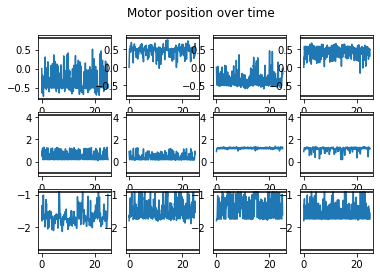

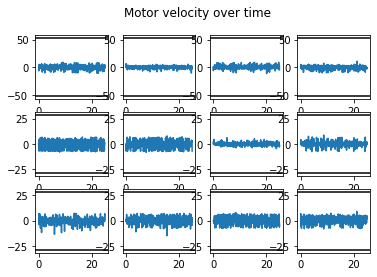

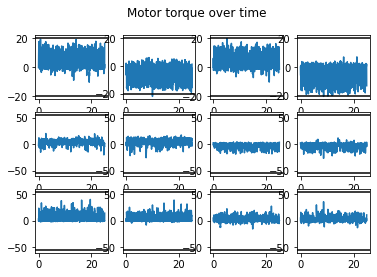

In [78]:
import matplotlib.pyplot as plt 

def plot_motor_velocity(stats, savedir):
    time = stats['time']
    motor_vel = stats['motor_vel']
    

    fig, ax = plt.subplots(3,4)
    fig.suptitle("Motor velocity over time")
    for leg in range(4):
        for jidx in range(3):
            i = 3 * leg + jidx
            ax[jidx, leg].plot(time, motor_vel[:, 3 * leg + jidx])
            ax[jidx, leg].axhline(MOTOR_MAX_VEL[i], color='black')
            ax[jidx, leg].axhline(-MOTOR_MAX_VEL[i], color='black')
    fig.savefig(savedir / 'motor_vel.png')

def plot_motor_torque(stats, savedir):
    time = stats['time']
    motor_torque = stats['motor_torque']

    fig, ax = plt.subplots(3,4)
    fig.suptitle("Motor torque over time")
    for leg in range(4):
        for jidx in range(3):
            i = 3 * leg + jidx
            ax[jidx, leg].plot(time, motor_torque[:, i])
            ax[jidx, leg].axhline(MOTOR_MAX_FORCE[i], color='black')
            ax[jidx, leg].axhline(-MOTOR_MAX_FORCE[i], color='black')
    fig.savefig(savedir / 'motor_torque.png')
    
def plot_motor_position(stats, savedir):
    time = stats['time']
    motor_pos = stats['motor_pos']

    fig, ax = plt.subplots(3,4)
    fig.suptitle("Motor position over time")
    for leg in range(4):
        for jidx in range(3):
            i = 3 * leg + jidx
            ax[jidx, leg].plot(time, motor_pos[:, i])
            ax[jidx, leg].axhline(MOTOR_POS_UPPER[i], color='black')
            ax[jidx, leg].axhline(MOTOR_POS_LOWER[i], color='black')
    fig.savefig(savedir / 'motor_pos.png')
            
plot_motor_position(stats, stats_dir)
plot_motor_velocity(stats, stats_dir)
plot_motor_torque(stats, stats_dir)
